# 量子機械学習を使った新しい素粒子現象の探索

この実習では、**量子・古典ハイブリッドアルゴリズム**の応用である**量子機械学習**の基本的な実装を学んだのち、その活用例として、**素粒子実験での新粒子探索**への応用を考えます。ここで学ぶ量子機械学習の手法は、変分量子アルゴリズムの応用として提案された、**量子回路学習**と呼ばれる学習手法{cite}`quantum_circuit_learning`です。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\expval}[3]{\langle #1 | #2 | #3 \rangle}$

## はじめに <a id='introduction'></a>

近年、機械学習の分野において**深層学習**（**ディープラーニング**）が注目を浴びています。ディープラーニングは**ニューラルネットワーク**の隠れ層を多層にすることで、入力と出力の間の複雑な関係を学習することができます。その学習結果を使って、新しい入力データに対して出力を予測することが可能になります。ここで学習する量子機械学習アルゴリズムは、このニューラルネットワークの部分を変分量子回路に置き換えたものです。つまり、ニューラルネットワークでの各ニューロン層への重みを調節する代わりに、変分量子回路のパラメータ（例えば回転ゲートの回転角）を調整することで入力と出力の関係を学習しようという試みです。
量子力学の重ね合わせの原理から、**指数関数的に増える多数の計算基底**を使って状態を表現できることが量子コンピュータの強みです。この強みを生かすことで、データ間の複雑な相関を学習できる可能性が生まれます。そこに量子機械学習の最も大きな強みがあると考えられています。

多項式で与えられる数の量子ゲートを使って、指数関数的に増える関数を表現できる可能性があるところに量子機械学習の強みがありますが、誤り訂正機能を持たない中規模の量子コンピュータ (*Noisy Intermediate-Scale Quantum*デバイス, 略してNISQ）で、古典計算を上回る性能を発揮できるか確証はありません。しかしNISQデバイスでの動作に適したアルゴリズムであるため、2019年3月にはIBMの実験チームによる実機での実装がすでに行われ、結果も論文{cite}`quantum_svm`として出版されています。

## 機械学習と深層学習 <a id='ml'></a>

機械学習を一言で（大雑把に）説明すると、与えられたデータを元に、ある予測を返すような機械を実現する工程だと言えます。例えば、2種類の変数$\mathbf{x}$と$\mathbf{y}$からなるデータ（$(x_i, y_i)$を要素とするベクトル、$i$は要素の添字）があったとして、その変数間の関係を求める問題として機械学習を考えてみましょう。つまり、変数$x_i$を引数とする関数$f$を考え、その出力$\tilde{y_i}=f(x_i)$が$\tilde{y}_i\simeq y_i$となるような関数$f$をデータから近似的に求めることに対応します。
一般的に、この関数$f$は変数$x$以外のパラメータを持っているでしょう。なので、そのパラメータ$\mathbf{w}$をうまく調整して、$y_i\simeq\tilde{y}_i$となる関数$f=f(x,\mathbf{w}^*)$とパラメータ$\mathbf{w}^*$を求めることが機械学習の鍵になります。

関数$f$を近似する方法の一つとして、現在主流になっているのが脳のニューロン構造を模式化したニューラルネットワークです。下図に示しているのは、ニューラルネットの基本的な構造です。丸で示しているのが構成ユニット（ニューロン）で、ニューロンを繋ぐ情報の流れを矢印で表しています。ニューラルネットには様々な構造が考えられますが、基本になるのは図に示したような層構造で、前層にあるニューロンの出力が次の層にあるニューロンへの入力になります。入力データ$x$を受ける入力層と出力$\tilde{y}$を出す出力層に加え、中間に複数の「隠れ層」を持つものを総称して深層ニューラルネットワークと呼びます。

```{image} figs/neural_net.png
:alt: var_circuit
:width: 500px
:align: center
```

では、もう少し数学的なモデルを見てみましょう。$l$層目にある$j$番目のユニット$u_j^l$に対して、前層（$l-1$番目）から$n$個の入力$o_k^{l-1}$ ($k=1,2,\cdots n$) がある場合、入力$o_k^{l-1}$への重みパラメータ$w_k^l$を使って

$$
o_j^l=g\left(\sum_{k=1}^n o_k^{l-1}w_k^l\right)
$$

となる出力$o_j^l$を考えます。図で示すと

```{image} figs/neuron.png
:alt: var_circuit
:width: 350px
:align: center
```

になります。関数$g$は活性化関数と呼ばれ、入力に対して非線形な出力を与えます。活性化関数としては、一般的にはシグモイド関数やReLU（Rectified Linear Unit）等の関数が用いられることが多いです。

関数$f(x,\mathbf{w}^*)$を求めるために、最適なパラメータ$\mathbf{w}^*$を決定するプロセス（学習と呼ばれる）が必要です。そのために、出力$\tilde{y}$とターゲットとなる変数$y$の差を測定する関数$L(\mathbf{w})$を考えます（一般に損失関数やコスト関数と呼ばれます）。

$$
L(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N L(f(x_i,\mathbf{w}),y_i)
$$

$N$は$(x_i, y_i)$データの数です。この損失関数$L(\mathbf{w})$を最小化するパラメータ$\mathbf{w}^*$を求めたいわけですが、それには誤差逆伝搬法と呼ばれる手法を使うことができることが知られています。この手法は、$L(\mathbf{w})$の各$w$に対する微分係数$\Delta_w L(\mathbf{w})$を求めて、

$$
w'=w-\epsilon\Delta_w L(\mathbf{w})
$$

のように$w$を更新することで、$L(\mathbf{w})$を最小化するというものです（$w$と$w'$は更新前と更新後のパラメータ）。$\epsilon\:(>0)$は学習率と呼ばれるパラメータで、これは基本的には私たちが手で決めてやる必要があります。

## 量子回路学習<a id='qml'></a>

変分量子回路を用いた量子回路学習アルゴリズムは、一般的には以下のような順番で量子回路に実装され、計算が行われます。

1. **学習データ**$\{(\mathbf{x}_i, y_i)\}$を用意する。$\mathbf{x}_i$は入力データのベクトル、$y_i$は入力データに対する真の値（教師データ）とする（$i$は学習データのサンプルを表す添字）。
2. 入力$\mathbf{x}$から何らかの規則で決まる回路$U_{\text{in}}(\mathbf{x})$（**特徴量マップ**と呼ぶ）を用意し、$\mathbf{x}_i$の情報を埋め込んだ入力状態$\ket{\psi_{\text{in}}(\mathbf{x}_i)} = U_{\text{in}}(\mathbf{x}_i)\ket{0}$を作る。
3. 入力状態にパラメータ$\boldsymbol{\theta}$に依存したゲート$U(\boldsymbol{\theta})$（**変分フォーム**）を掛けたものを出力状態$\ket{\psi_{\text{out}}(\mathbf{x}_i,\boldsymbol{\theta})} = U(\boldsymbol{\theta})\ket{\psi_{\text{in}}(\mathbf{x}_i)}$とする。
4. 出力状態のもとで何らかの**観測量**を測定し、測定値$O$を得る。例えば、最初の量子ビットで測定したパウリ$Z$演算子の期待値$\langle Z_1\rangle = \expval{\psi_{\text{out}}}{Z_1}{\psi_{\text{out}}}$などを考える。
5. $F$を適当な関数として、$F(O)$をモデルの出力$y(\mathbf{x}_i,\boldsymbol{\theta})$とする。
6. 真の値$y_i$と出力$y(\mathbf{x}_i,\boldsymbol{\theta})$の間の乖離を表す**コスト関数**$L(\boldsymbol{\theta})$を定義し、古典計算でコスト関数を計算する。
7. $L(\boldsymbol{\theta})$が小さくなるように$\boldsymbol{\theta}$を更新する。
7. 3-7のプロセスを繰り返すことで、コスト関数を最小化する$\boldsymbol{\theta}=\boldsymbol{\theta^*}$を求める。
8. $y(\mathbf{x},\boldsymbol{\theta^*})$が学習によって得られた**予測モデル**になる。

```{image} figs/var_circuit.png
:alt: var_circuit
:width: 700px
:align: center
```


この順に量子回路学習アルゴリズムを実装していきましょう。まず、必要なライブラリを最初にインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit_ibm_runtime import Session, Sampler as RuntimeSampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError

/usr/local/lib/python3.10/dist-packages/dateutil/zoneinfo/__init__.py:26: UserWarning: I/O error(2): No such file or directory
  warnings.warn("I/O error({0}): {1}".format(e.errno, e.strerror))


## 初歩的な例<a id='example'></a>

ある入力$\{x_i\}$と、既知の関数$f$による出力$y_i=f(x_i)$が学習データとして与えられた時に、そのデータから関数$f$を近似的に求める問題を考えてみます。例として、$f(x)=x^3$としてみます。

### 学習データの準備<a id='func_data'></a>

まず、学習データを準備します。$x_{\text{min}}$と$x_{\text{max}}$の範囲でデータを`num_x_train`個ランダムに取った後、正規分布に従うノイズを追加しておきます。`nqubit`が量子ビット数、`nlayer`が変分フォームのレイヤー数（後述）を表します。

In [2]:
random_seed = 0
rng = np.random.default_rng(random_seed)

# Qubit数、変分フォームのレイヤー数、訓練サンプル数の定義など
nqubit = 3
nlayer = 5
x_min = -1.
x_max = 1.
num_x_train = 30
num_x_validation = 20

# 関数の定義
func_to_learn = lambda x: x ** 3

# 学習用データセットの生成
x_train = rng.uniform(x_min, x_max, size=num_x_train)
y_train = func_to_learn(x_train)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train_noise = y_train + rng.normal(0., mag_noise, size=num_x_train)

# 検証用データセットの生成
x_validation = rng.uniform(x_min, x_max, size=num_x_validation)
y_validation = func_to_learn(x_validation) + rng.normal(0., mag_noise, size=num_x_validation)

### 量子状態の生成<a id='func_state_preparation'></a>

次に、入力$x_i$を初期状態$\ket{0}^{\otimes n}$に埋め込むための回路$U_{\text{in}}(x_i)$（特徴量マップ）を作成します。まず参考文献{cite}`quantum_circuit_learning`に従い、回転ゲート$R_j^Y(\theta)=e^{-i\theta Y_j/2}$と$R_j^Z(\theta)=e^{-i\theta Z_j/2}$を使って

$$
U_{\text{in}}(x_i) = \prod_j R_j^Z(\cos^{-1}(x^2))R_j^Y(\sin^{-1}(x))
$$

と定義します。この$U_{\text{in}}(x_i)$をゼロの標準状態に適用することで、入力$x_i$は$\ket{\psi_{\text{in}}(x_i)}=U_{\text{in}}(x_i)\ket{0}^{\otimes n}$という量子状態に変換されることになります。

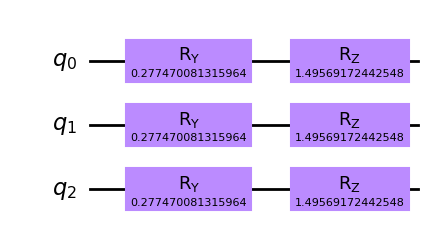

In [3]:
u_in = QuantumCircuit(nqubit, name='U_in')
x = Parameter('x')

for iq in range(nqubit):
    # parameter.arcsin()はparameterに値vが代入された時にarcsin(v)になるパラメータ表現
    u_in.ry(x.arcsin(), iq)
    # arccosも同様
    u_in.rz((x * x).arccos(), iq)

u_in.bind_parameters({x: x_train[0]}).draw('mpl')

### 変分フォームを使った状態変換<a id='func_variational_form'></a>

#### 変分量子回路$U(\boldsymbol{\theta})$の構成
次に、最適化すべき変分量子回路$U(\boldsymbol{\theta})$を作っていきます。これは以下の3つの手順で行います。

1. 2量子ビットゲートの作成（$\to$ 量子ビットをエンタングルさせる）
2. 回転ゲートの作成
3. 1.と2.のゲートを交互に組み合わせ、1つの大きな変分量子回路$U(\boldsymbol{\theta})$を作る

#### 2量子ビットゲートの作成
ここではControlled-$Z$ゲート（$CZ$）を使ってエンタングルさせ、モデルの表現能力を上げることを目指します。

#### 回転ゲートと$U(\boldsymbol{\theta})$の作成
$CZ$ゲートを使ってエンタングルメントを生成する回路$U_{\text{ent}}$と、$j \:(=1,2,\cdots n)$番目の量子ビットに適用する回転ゲート

$$
U_{\text{rot}}(\theta_j^l) = R_j^Y(\theta_{j3}^l)R_j^Z(\theta_{j2}^l)R_j^Y(\theta_{j1}^l)
$$

を掛けたものを組み合わせて、変分量子回路$U(\boldsymbol{\theta})$を構成します。ここで$l$は量子回路の層を表していて、$U_{\text{ent}}$と上記の回転ゲートを合計$d$層繰り返すことを意味しています。実際は、この演習では最初に回転ゲート$U_{\text{rot}}$を一度適用してから$d$層繰り返す構造を使うため、全体としては

$$
U\left(\{\theta_j^l\}\right) = \prod_{l=1}^d\left(\left(\prod_{j=1}^n U_{\text{rot}}(\theta_j^l)\right) \cdot U_{\text{ent}}\right)\cdot\prod_{j=1}^n U_{\text{rot}}(\theta_j^0)
$$

という形式の変分量子回路を用いることになります。つまり、変分量子回路は全体で$3n(d+1)$個のパラメータを含んでいます。$\boldsymbol{\theta}$の初期値ですが、$[0, 2\pi]$の範囲でランダムに設定するものとします。

54 parameters


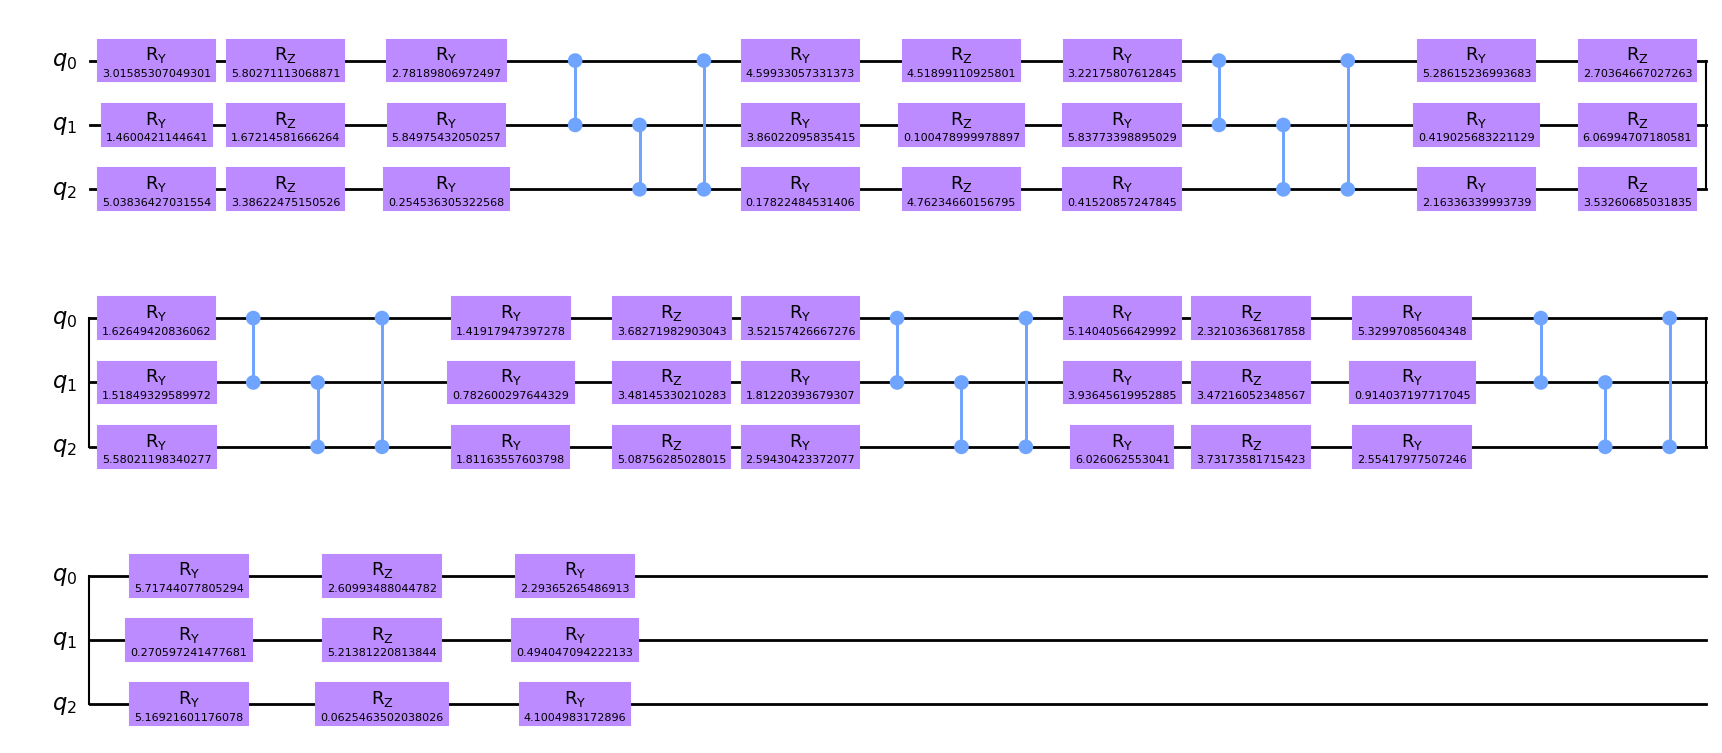

In [4]:
u_out = QuantumCircuit(nqubit, name='U_out')

# 長さ0のパラメータ配列
theta = ParameterVector('θ', 0)

# thetaに一つ要素を追加して最後のパラメータを返す関数
def new_theta():
    theta.resize(len(theta) + 1)
    return theta[-1]

for iq in range(nqubit):
    u_out.ry(new_theta(), iq)

for iq in range(nqubit):
    u_out.rz(new_theta(), iq)

for iq in range(nqubit):
    u_out.ry(new_theta(), iq)

for il in range(nlayer):
    for iq in range(nqubit):
        u_out.cz(iq, (iq + 1) % nqubit)

    for iq in range(nqubit):
        u_out.ry(new_theta(), iq)

    for iq in range(nqubit):
        u_out.rz(new_theta(), iq)

    for iq in range(nqubit):
        u_out.ry(new_theta(), iq)

print(f'{len(theta)} parameters')

theta_vals = rng.uniform(0., 2. * np.pi, size=len(theta))

u_out.bind_parameters(dict(zip(theta, theta_vals))).draw('mpl')

### 測定とモデル出力<a id='func_measurement'></a>

モデルの出力（予測値）として、状態$\ket{\psi_{\text{out}}(\mathbf{x},\boldsymbol{\theta})}=U(\boldsymbol{\theta})\ket{\psi_{\text{in}}(\mathbf{x})}$の元で最初の量子ビットを$Z$基底で測定した時の期待値を使うことにします。つまり$y(\mathbf{x},\boldsymbol{\theta}) = \langle Z_0(\mathbf{x},\boldsymbol{\theta}) \rangle = \expval{\psi_{\text{out}}(\mathbf{x},\boldsymbol{\theta})}{Z_0}{\psi_{\text{out}}(\mathbf{x},\boldsymbol{\theta})}$です。

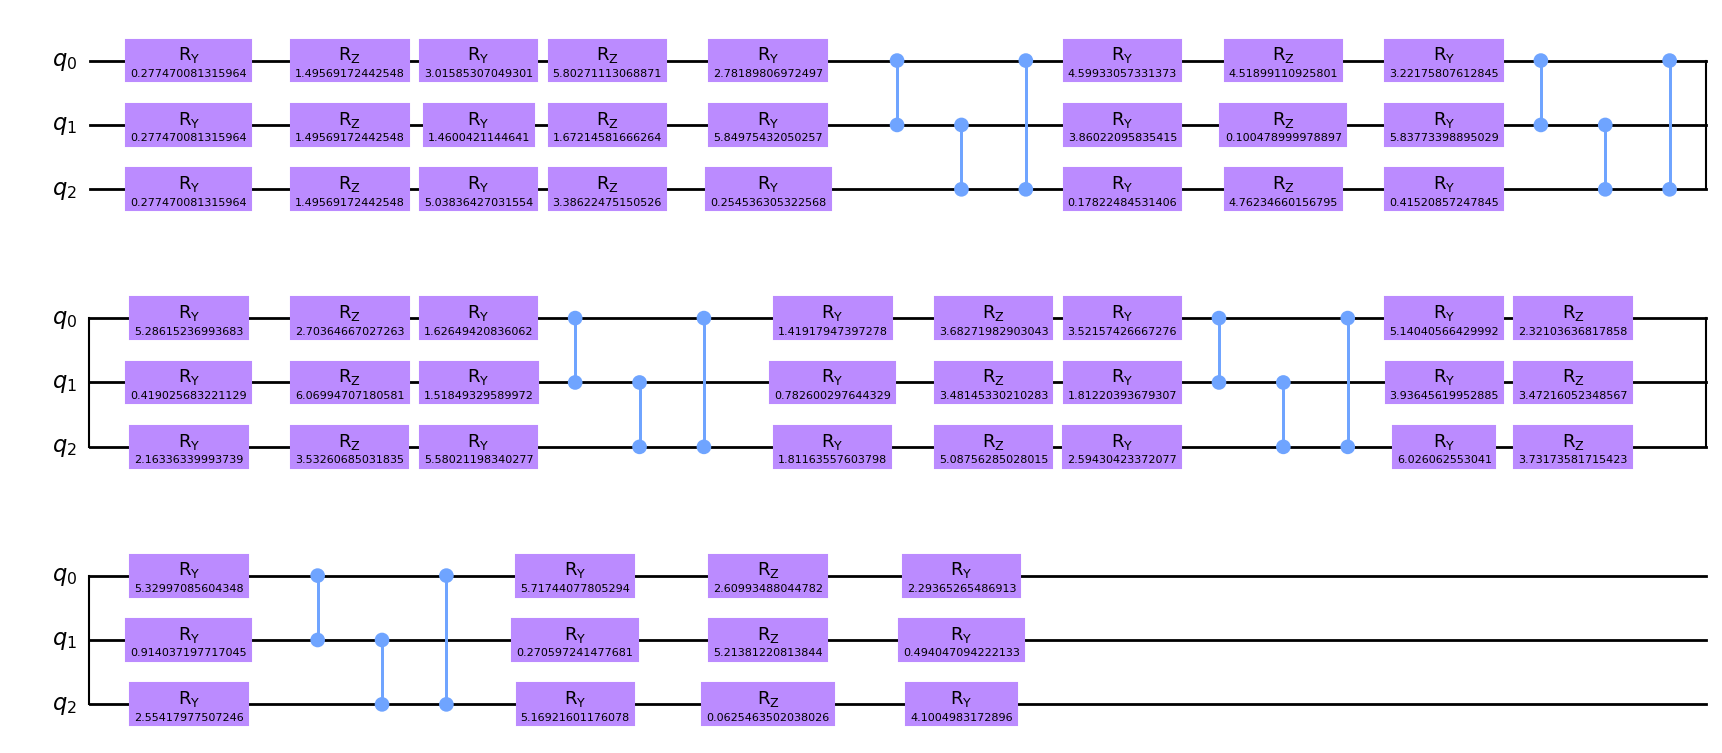

In [5]:
model = QuantumCircuit(nqubit, name='model')

model.compose(u_in, inplace=True)
model.compose(u_out, inplace=True)

bind_params = dict(zip(theta, theta_vals))
bind_params[x] = x_train[0]

model.bind_parameters(bind_params).draw('mpl')

In [6]:
# 今回はバックエンドを利用しない（量子回路シミュレーションを簡略化した）Estimatorクラスを使う
estimator = Estimator()

# 与えられたパラメータの値とxの値に対してyの値を計算する
def yvals(param_vals, x_vals=x_train):
    circuits = list()
    for x_val in x_vals:
        # xだけ数値が代入された変分回路
        circuits.append(model.bind_parameters({x: x_val}))

    # 観測量はIIZ（右端が第0量子ビット）
    observable = SparsePauliOp('I' * (nqubit - 1) + 'Z')

    # shotsは関数の外で定義
    job = estimator.run(circuits, [observable] * len(circuits), [param_vals] * len(circuits), shots=shots)

    return np.array(job.result().values)

def objective_function(param_vals):
    return np.sum(np.square(y_train_noise - yvals(param_vals)))

def callback_function(param_vals):
    # lossesは関数の外で定義
    losses.append(objective_function(param_vals))

    if len(losses) % 10 == 0:
        print(f'COBYLA iteration {len(losses)}: cost={losses[-1]}')

コスト関数$L$として、モデルの予測値$y(x_i, \theta)$と真の値$y_i$の平均2乗誤差の総和を使っています。

では、最後にこの回路を実行して、結果を見てみましょう。

In [7]:
# COBYLAの最大ステップ数
maxiter = 50
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.05
# バックエンドでのショット数
shots = 1000

optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function)

In [8]:
# テキスト作成用のセル - わざと次のセルでエラーを起こさせる
import os
if os.getenv('JUPYTERBOOK_BUILD') == '1':
    del objective_function

In [9]:
initial_params = rng.uniform(0., 2. * np.pi, size=len(theta))

losses = list()
min_result = optimizer.minimize(objective_function, initial_params)

NameError: name 'objective_function' is not defined

In [10]:
# テキスト作成用のセルなので無視してよい

if os.getenv('JUPYTERBOOK_BUILD') == '1':
    import pickle

    with open('data/qc_machine_learning_xcube.pkl', 'rb') as source:
        min_result, losses = pickle.load(source)

コスト値の推移をプロットします。

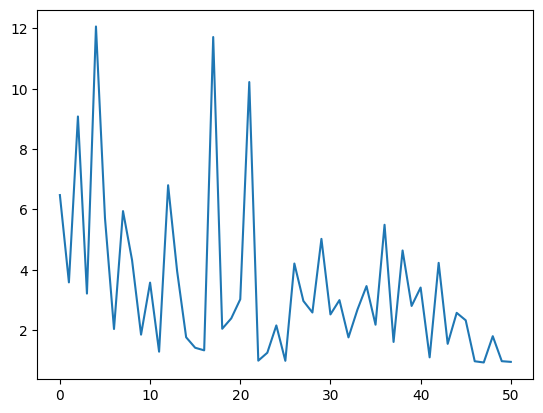

In [11]:
plt.plot(losses)

最適パラメータ値でのモデルの出力値をx_minからx_maxまで均一にとった100点で確認します。

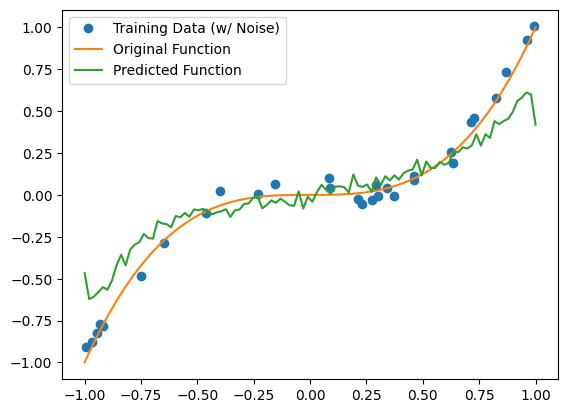

In [12]:
x_list = np.linspace(x_min, x_max, 100)

y_pred = yvals(min_result.x, x_vals=x_list)

# 結果を図示する
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.plot(x_list, np.array(y_pred), label='Predicted Function')
plt.legend();

生成された図を確認してください。ノイズを印加した学習データの分布から、元の関数$f(x)=x^3$をおおよそ導き出せていることが分かると思います。

この実習では計算を早く収束させるために、COBYLAオプティマイザーをCallする回数の上限`maxiter`を50、計算をストップする精度の許容範囲`tol`を0.05とかなり粗くしています。`maxiter`を大きくするあるいは`tol`を小さくするなどして、関数を近似する精度がどう変わるか確かめてみてください（ただ同時に`maxiter`を大きくかつ`tol`を小さくしすぎると、計算に非常に時間がかかります）。

## 素粒子現象の探索への応用<a id='susy'></a>

次の実習課題では、素粒子物理の基本理論（**標準模型**と呼ばれる）を超える新しい理論の枠組みとして知られている「**超対称性理論**」（*Supersymmetry*、略してSUSY）で存在が予言されている新粒子の探索を考えてみます。

左下の図は、グルーオン$g$が相互作用してヒッグス粒子$h$を作り、それが2つのSUSY粒子$\chi^+\chi^-$に崩壊する過程を示しています。$\chi^+$粒子はさらに崩壊し、最終的には$\ell^+\ell^-\nu\nu\chi^0\chi^0$という終状態に落ち着くとします。右下の図は標準模型で存在が知られている過程を表していて、クォーク$q$と反クォーク$\bar{q}$が相互作用して$W$ボソン対を作り、それが$\ell^+\ell^-\nu\nu$に崩壊しています。

```{image} figs/susy_bg.png
:alt: susy_bg
:width: 700px
:align: center
```
(図の引用：参考文献{cite}`dl_susy`)

左と右の過程を比べると、終状態の違いは$\chi^0\chi^0$が存在しているかどうかだけですね。この$\chi^0$という粒子は検出器と相互作用しないと考えられているので、この二つの過程の違いは（大雑把に言うと）実際の検出器では観測できないエネルギーの大きさにしかなく、探索することが難しい問題と考えることができます。以上のような状況で、この二つの物理過程を量子回路学習で分類できるかどうかを試みます。

### 学習データの準備<a id='susy_data'></a>

学習に用いるデータは、カリフォルニア大学アーバイン校（UC Irvine）の研究グループが提供する[機械学習レポジトリ](https://archive.ics.uci.edu/ml/index.php)の中の[SUSYデータセット](https://archive.ics.uci.edu/ml/datasets/SUSY)です。このデータセットの詳細は文献{cite}`dl_susy`に委ねますが、ある特定のSUSY粒子生成反応と、それに良く似た特徴を持つ背景事象を検出器で観測した時に予想される信号（運動学的変数）をシミュレートしたデータが含まれています。

探索に役立つ運動学的変数をどう選ぶかはそれ自体が大事な研究トピックですが、ここでは簡単のため、前もって役立つことを経験上知っている変数を使います。以下で、学習に使う運動学的変数を選んで、その変数を指定したサンプルを訓練用とテスト用に準備します。

In [13]:
# ファイルから変数を読み出す
df = pd.read_csv("data/SUSY_1K.csv",
                 names=('isSignal', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep2_pt', 'lep2_eta',
                        'lep2_phi', 'miss_ene', 'miss_phi', 'MET_rel', 'axial_MET', 'M_R', 'M_TR_2',
                        'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos_theta_r1'))

# 学習に使う変数の数
feature_dim = 3  # dimension of each data point

# 3, 5, 7変数の場合に使う変数のセット
if feature_dim == 3:
    selected_features = ['lep1_pt', 'lep2_pt', 'miss_ene']
elif feature_dim == 5:
    selected_features = ['lep1_pt', 'lep2_pt', 'miss_ene', 'M_TR_2', 'M_Delta_R']
elif feature_dim == 7:
    selected_features = ['lep1_pt', 'lep1_eta', 'lep2_pt', 'lep2_eta', 'miss_ene', 'M_TR_2', 'M_Delta_R']

# 学習に使う事象数: trainは訓練用サンプル、testはテスト用サンプル
train_size = 20
test_size = 20

df_sig = df.loc[df.isSignal==1, selected_features]
df_bkg = df.loc[df.isSignal==0, selected_features]

# サンプルの生成
df_sig_train = df_sig.values[:train_size]
df_bkg_train = df_bkg.values[:train_size]
df_sig_test = df_sig.values[train_size:train_size + test_size]
df_bkg_test = df_bkg.values[train_size:train_size + test_size]
# 最初のtrain_size事象がSUSY粒子を含む信号事象、残りのtrain_size事象がSUSY粒子を含まない背景事象
train_data = np.concatenate([df_sig_train, df_bkg_train])
# 最初のtest_size事象がSUSY粒子を含む信号事象、残りのtest_size事象がSUSY粒子を含まない背景事象
test_data = np.concatenate([df_sig_test, df_bkg_test])

# one-hotベクトル（信号事象では第1次元の第0要素が1、背景事象では第1次元の第1要素が1）
train_label_one_hot = np.zeros((train_size * 2, 2))
train_label_one_hot[:train_size, 0] = 1
train_label_one_hot[train_size:, 1] = 1

test_label_one_hot = np.zeros((test_size * 2, 2))
test_label_one_hot[:test_size, 0] = 1
test_label_one_hot[test_size:, 1] = 1

#datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
#datapoints_tr, class_to_label_tr = split_dataset_to_data_and_labels(training_input)

mms = MinMaxScaler((-1, 1))
norm_train_data = mms.fit_transform(train_data)
norm_test_data = mms.transform(test_data)

### 量子状態の生成<a id='susy_state_preparation'></a>

次は特徴量マップ$U_{\text{in}}(\mathbf{x}_i)$の作成ですが、ここでは参考文献{cite}`quantum_svm`に従い、

$$
U_{\phi_{\{k\}}}(\mathbf{x}_i)=\exp\left(i\phi_{\{k\}}(\mathbf{x}_i)Z_k\right)
$$

あるいは

$$
U_{\phi_{\{l,m\}}}(\mathbf{x}_i)=\exp\left(i\phi_{\{l,m\}}(\mathbf{x}_i)Z_lZ_m\right)
$$

とします（$k$、$l$、$m$は入力値$\mathbf{x}_i$のベクトル要素の添字）。この特徴量マップは、パウリZ演算子の形から前者をZ特徴量マップ、後者をZZ特徴量マップと呼ぶことがあります。ここで$\phi_{\{k\}}(\mathbf{x}_i)=x_i^{(k)}$（$x_i^{(k)}$は$\mathbf{x}_i$の$k$番目要素）、$\phi_{\{l,m\}}(\mathbf{x}_i)=(\pi-x_i^{(l)})(\pi-x_i^{(m)})$（$x_i^{(l,m)}$は$\mathbf{x}_i$の$l,m$番目要素）と決めて、入力値$\mathbf{x}_i$を量子ビットに埋め込みます。Z特徴量マップは入力データの各要素を直接量子ビットに埋め込みます（つまり$\phi_{\{k\}}(\mathbf{x}_i)$は1入力に対して1量子ビットを使う）。ZZ特徴量マップは実際はZ特徴量マップを含む形で使うことが多いため、$\phi_{\{l,m\}}(\mathbf{x}_i)$の場合も$\phi_{\{k\}}(\mathbf{x}_i)$と同数の量子ビットに対して$(l,m)$を循環的に指定して埋め込むことになります。ZZ特徴量マップでは量子ビット間にエンタングルメントを作っているため、古典計算では難しい特徴量空間へのマッピングになっていると考えられます。

この$U_\phi(\mathbf{x}_i)$にアダマール演算子を組み合わせることで、全体として、Z特徴量マップは

$$
U_{\text{in}}(\mathbf{x}_i) = U_{\phi}(\mathbf{x}_i)H^{\otimes n},\:\:U_{\phi}(\mathbf{x}_i) = \exp\left(i\sum_{k=1}^nx_i^{(k)}Z_k\right)
$$

ZZ特徴量マップは

$$
U_{\text{in}}(\mathbf{x}_i) = U_{\phi}(\mathbf{x}_i)H^{\otimes n},\:\:U_{\phi}(\mathbf{x}_i) = \exp\left(i\sum_{k=1}^n(\pi-x_i^{(k)})(\pi-x_i^{(k\%n+1)})Z_kZ_{k\%n+1}\right)\exp\left(i\sum_{k=1}^nx_i^{(k)}Z_k\right)
$$

となります。$U_{\phi}(\mathbf{x}_i)H^{\otimes n}$を複数回繰り返すことでより複雑な特徴量マップを作ることができるのは、上の例の場合と同じです。

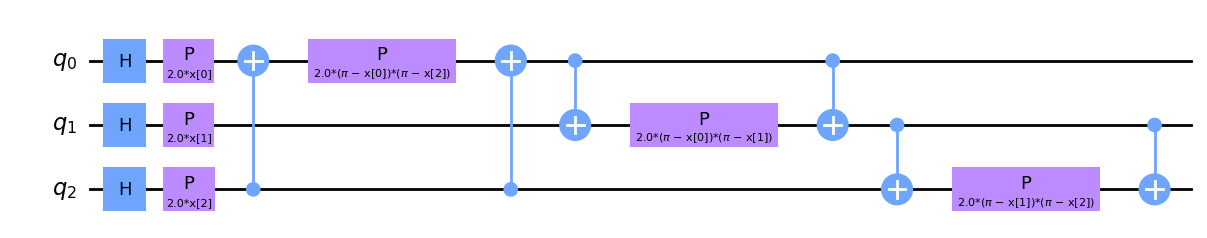

In [14]:
#feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=1)
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='circular')
feature_map.decompose().draw('mpl')

### 変分フォームを使った状態変換<a id='susy_variational_form'></a>

変分量子回路$U(\boldsymbol{\theta})$は上の初歩的な例で用いた回路とほぼ同じですが、回転ゲートとして

$$
U_{\text{rot}}(\theta_j^l) = R_j^Z(\theta_{j2}^l)R_j^Y(\theta_{j1}^l)
$$

を使います。上の例では$U(\boldsymbol{\theta})$を自分で組み立てましたが、Qiskitにはこの$U(\boldsymbol{\theta})$を実装するAPIがすでに準備されているので、ここではそれを使います。

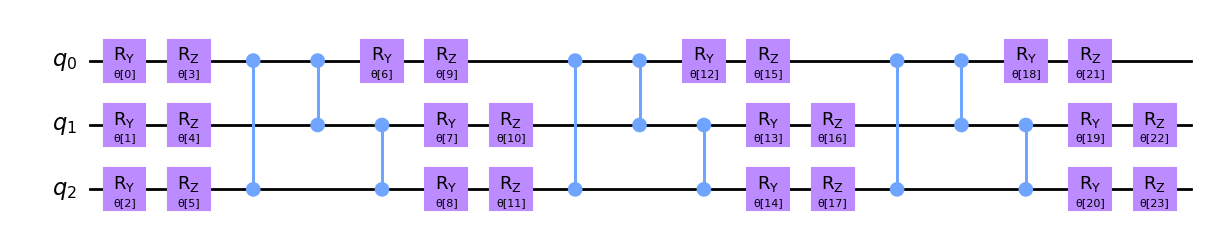

In [15]:
ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='circular', reps=3)
#ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry'], entanglement_blocks='cz', entanglement='circular', reps=3)
ansatz.decompose().draw('mpl')

### 測定とモデル出力<a id='susy_measurement'></a>

測定やパラメータの最適化、コスト関数の定義も初歩的な例で用いたものとほぼ同じです。QiskitのVQCというクラスを用いるので、プログラムはかなり簡略化されています。

VQCクラスでは、特徴量マップと変分フォームを結合させ、入力特徴量とパラメータ値を代入し、測定を行い、目的関数を計算し、パラメータのアップデートを行う、という一連の操作を内部で行なってしまいます。測定を行うのに使用するのはSamplerというクラスで、これはEstimatorと同様の働きをしますが、後者が観測量の期待値を計算するのに対し、前者はすべての量子ビットをZ基底で測定した結果のビット列の確率分布を出力します。VQCではこの分布を利用して分類を行います。今回は2クラス分類なので、入力の各事象に対して、q0の測定値が0である確率が、それが信号事象である確率（モデルの予測）に対応します。

In [16]:
# 上のEstimatorと同じく、バックエンドを使わずシミュレーションを簡略化したSampler
sampler = Sampler()

# 実機で実行する場合
# instance = 'ibm-q/open/main'

# try:
#     service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
# except AccountNotFoundError:
#     service = QiskitRuntimeService(channel='ibm_quantum', token='__paste_your_token_here__',
#                                    instance=instance)

# backend_name = 'ibm_washington'
# session = Session(service=service, backend=backend_name)

# sampler = RuntimeSampler(session=session)

maxiter = 300

optimizer = COBYLA(maxiter=maxiter, disp=True)

objective_func_vals = []
# Draw the value of objective function every time when the fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    #print('obj_func_eval =',obj_func_eval)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(objective_func_vals)
    plt.show()

vqc = VQC(num_qubits=feature_dim,
          feature_map=feature_map,
          ansatz=ansatz,
          loss="cross_entropy",
          optimizer=optimizer,
          callback=callback_graph,
          sampler=sampler)

In [17]:
# テキスト作成用のセル - わざと次のセルでエラーを起こさせる
if os.getenv('JUPYTERBOOK_BUILD') == '1':
    del objective_func_vals

In [18]:
vqc.fit(norm_train_data, train_label_one_hot)

# 実機で実行している（RuntimeSamplerを使っている）場合
# session.close()

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


NameError: name 'objective_func_vals' is not defined

In [19]:
# テキスト作成用のセルなので無視してよい
with open('data/vqc_machine_learning_susycost.pkl', 'rb') as source:
    fig = pickle.load(source)

with open('data/vqc_machine_learning_susyresult.pkl', 'rb') as source:
    vqc._fit_result = pickle.load(source)

print('''   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  300   F = 7.527796E-01    MAXCV = 0.000000E+00
   X = 2.769828E+00   2.690659E+00   2.209438E+00  -6.544334E-01   1.791658E+00
       5.891710E-01  -4.081896E-02   5.725357E-01   1.662590E+00  -5.402978E-01
       2.029238E+00   1.562530E-01   1.229339E+00   1.596802E+00   2.692169E-01
      -5.828812E-01   1.891610E+00   7.527701E-01  -6.604400E-01   1.587293E+00
       1.194641E+00   1.505717E-01''')

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  300   F = 7.527796E-01    MAXCV = 0.000000E+00
   X = 2.769828E+00   2.690659E+00   2.209438E+00  -6.544334E-01   1.791658E+00
       5.891710E-01  -4.081896E-02   5.725357E-01   1.662590E+00  -5.402978E-01
       2.029238E+00   1.562530E-01   1.229339E+00   1.596802E+00   2.692169E-01
      -5.828812E-01   1.891610E+00   7.527701E-01  -6.604400E-01   1.587293E+00
       1.194641E+00   1.505717E-01


In [20]:
train_score = vqc.score(norm_train_data, train_label_one_hot)
test_score = vqc.score(norm_test_data, test_label_one_hot)

print(f'--- Classification Train score: {train_score} ---')
print(f'--- Classification Test score:  {test_score} ---')

--- Classification Train score: 0.75 ---
--- Classification Test score:  0.275 ---


この結果を見てどう思うでしょうか？機械学習を知っている方であれば、この結果はあまり良いようには見えませんね。。訓練用のデータでは学習ができている、つまり信号とバックグラウンドの選別ができていますが、テスト用のサンプルでは選別性能が悪くなっています。これは「過学習」を起こしている場合に見られる典型的な症状で、訓練データのサイズに対して学習パラメータの数が多すぎるときによく起こります。

試しに、データサンプルの事象数を50や100に増やして実行し、結果を調べてみてください（処理時間は事象数に比例して長くなるので要注意）。